# Shallow Bayesian sparse coding networks

Here we invesigate Bayesian sparse coding networks consisting only of a single "hidden" layer. We will extend the standard SCN appraoch to a full Bayesian treatment of SCNs. Unlike SCNs where inference and learning relies on MAP estimates for latent variables and MLE estimate for weights, we will formulate Bayesian SCNs with defined prior over weights and the full estimate of the posterior of latent variables and weights.

The investigation is inspired by the following paper: "Illing, Bernd, Wulfram Gerstner, and Johanni Brea. "Biologically plausible deep learning—but how far can we go with shallow networks?." Neural Networks 118 (2019): 90-101". The authors were interested to understand the limitations of shallow networks for image classification, with the aim to test local biologically plaussible learning rules. Sparse coding assumptions leads to biologically plausible neuronal dynamics and hebbian like learning rules.  

Here we will utilise the same paradigm of shallow networks, to test how Bayesian treatment of SCNs changes the performance of classification algorithms. We will start with the following generative model over hidden states $\pmb{a}$ (neuronal activations) and parameter (network weights) $\pmb{W}_1$, and $\pmb{W}_2$

\begin{equation}
   p\left(\pmb{X}, \pmb{A}, \pmb{L}|\pmb{\Theta}\right) = \prod_{n=1}^N p(\pmb{x}^n|\pmb{a}^n, \pmb{\Theta}) p(l^n|\pmb{a}^n, \pmb{\Theta})p(\pmb{a}^n|\pmb{\Theta})
\end{equation}

where

\begin{equation}
    \begin{split}
        p\left(\pmb{x}^n|\pmb{a}^n, \pmb{\Theta}\right) &= \pmb{\mathcal{N}}\left(\pmb{x}^n; \pmb{L}\pmb{W}^T_{1} \pmb{a}^n + \pmb{b}_1, \pmb{L}\pmb{L}^T \right) \\
        p\left(l^n|\pmb{a}^n, \pmb{\Theta}\right) &= \prod_i s_{\max}^i \left( \pmb{w}^T_{2,i} \pmb{a}^n + \pmb{b}_2 \right)^{\delta_{l^n, i}} \\
        p\left(\pmb{a}^n|\pmb{\Theta}\right) &\propto \prod_i e^{-\lambda C(a_i)}\\
    \end{split}
\end{equation}
The MAP estimate with respect to hidden states $\pmb{a}^n$ is obtained as a solution the following system of ODEs

\begin{equation}
\begin{split}
\frac{d \pmb{u}^n}{d t} &= - \pmb{u}^n + \pmb{W}_1 \pmb{\epsilon}_1^n + \pmb{W}_2 \pmb{\epsilon}^n_2 - \pmb{V} \pmb{a}^n \\
a^n_i &= \phi\left(u^n_i\right) = \begin{cases} 0, & \text{ for } u_i^n < \alpha\lambda \\ \frac{u^n_i - \alpha\lambda}{1 + e^{\gamma (u^n_i - \lambda) }},& \text{ for } u^n_i \geq \alpha\lambda \end{cases}
\end{split}
\end{equation}

where $\pmb{V} = \pmb{W}_1 \cdot \pmb{W}_1^T - \pmb{I}$, $\pmb{\epsilon}_1^n = \pmb{L}^{-1}\left(\pmb{x}_n - \pmb{b}_1 \right)$, and $\pmb{\epsilon}^n_2 = \pmb{l}^n - \pmb{s}_{\max}\left( \pmb{W}_2^T \pmb{a}^n + \pmb{b}_2 \right)$, for $\pmb{l}^n = \text{onehot}(l^n)$.

In [2]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

####################
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
######################################################

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from jax import random, vmap, nn
from jax.nn import one_hot
from flax import linen as fnn
from typing import Any, Callable, Sequence, Optional

sns.set(context='notebook')

In [3]:
def whitening(x, mean, W=None, V=None):
    if W is None:
        W, V = jnp.linalg.eigh(jnp.cov(x.T))
    
    return (x - mean) @ jnp.linalg.inv(V @ jnp.diag(jnp.sqrt(W))).T, W, V

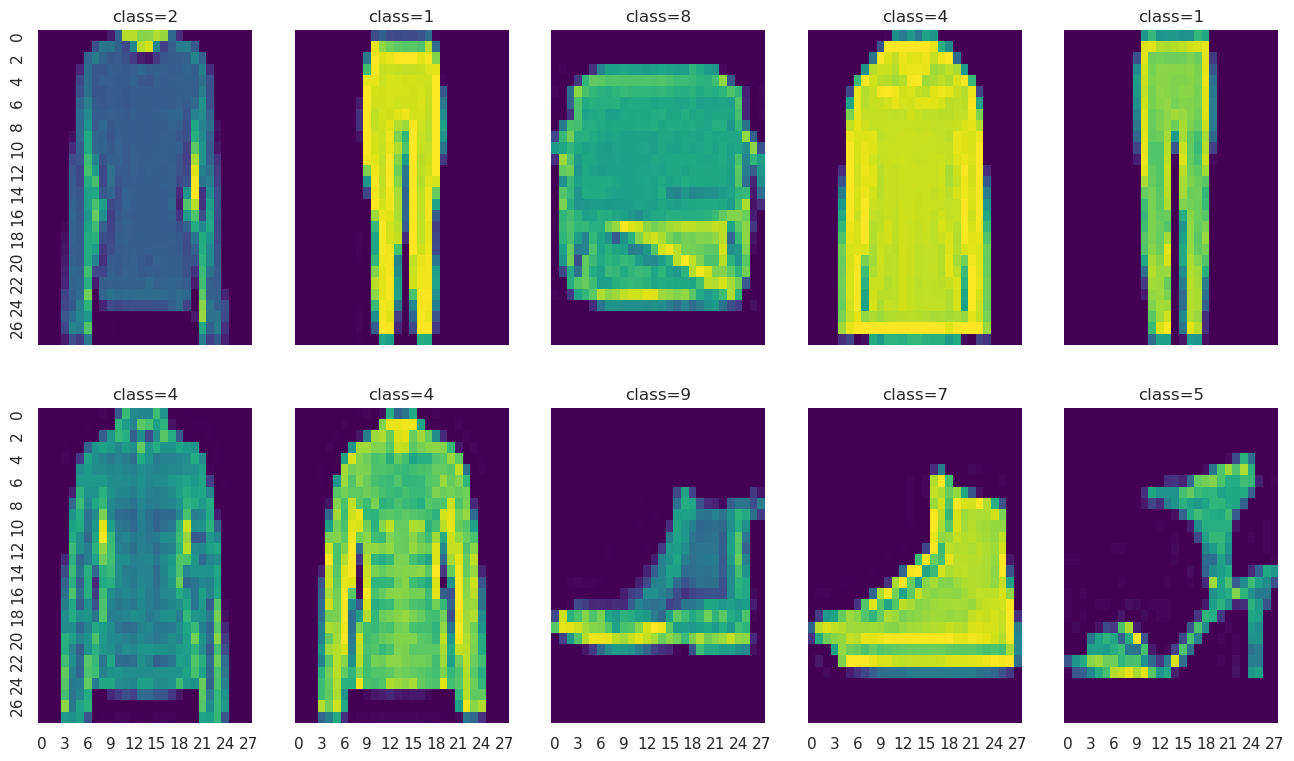

In [4]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')
fig, axes = plt.subplots(2, 5, figsize=(16, 9), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].squeeze(), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(test_ds['image'][n].squeeze(), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)
    axes[1, n].set_title('class={}'.format(test_ds['label'][n]))


mean = train_ds['image'].mean(0).reshape(-1)
train_ds['image'], W, V = whitening(train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1), mean)
test_ds['image'], _, _ = whitening(test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1), mean, W, V)

num_hn = [10, 20, 40, 60, 80, 100]

In [5]:
import equinox as eqx
import diffrax
from functools import partial
from jax.nn import relu, sigmoid, softmax

def activation(lam, alpha, gamma, x):
    return relu( (x - alpha * lam) * sigmoid(gamma * (x - lam)) )

class MirrorDescent(eqx.Module):    
    hidden_size: int
    W_1: Any
    W_2: Any
    b: Any
    b_2: Any
    V: Any
    a: Callable
    
    def __init__(self, hidden_size, W_1, b_1, W_2, b_2, lam=0.01, alpha=0., gamma=1., **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.W_1 = W_1  # excitatory weights
        self.W_2 = W_2  # excitatory weights
        self.b_2 = b_2

        self.V = W_1 @ W_1.T - jnp.eye(hidden_size)
        self.b = W_1 @ b_1
            
        self.a = partial(activation, lam, alpha, gamma)
        
    def __call__(self, t, y, args):
        a = self.a(y)
        if args['L'] is not None:
            w_eps = self.W_2 @ (args['L'] - softmax(a @ self.W_2 + self.b_2))
        else:
            w_eps = 0. 

        return - y + self.W_1 @ args['X'] - self.V @ a - self.b + w_eps
    
class NeuralActivity(eqx.Module):
    func: Callable
    initial: Any
    solver: Callable
    
    def __init__(self, hidden_size, func, solver, **kwargs):
        super().__init__(**kwargs)
        self.initial = jnp.zeros(hidden_size)
        self.func = func
        self.solver = solver

    def __call__(self, dt0, ts, images=None, labels=None, evolving_out=False):
        term = diffrax.ODETerm(self.func)
        solver = self.solver()
        
        args = {
            'X': images,
            'L': labels
        }
        
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        
        solution = diffrax.diffeqsolve(
            term,
            solver,
            args=args,
            t0=ts[0],
            t1=ts[-1],
            dt0=dt0,
            y0=self.initial,
            saveat=saveat,
        )
        
        return self.func.a(solution.ys)

In [9]:
import numpyro
import numpyro.distributions as dist
from jax import lax

def map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x=None, batch_y=None):
    dt = 0.25 
    ts = [0, 10]
    func = MirrorDescent(
        num_hidden, 
        lax.stop_gradient(W_1),
        lax.stop_gradient(b_1),
        lax.stop_gradient(W_2),
        lax.stop_gradient(b_2),
        lam=lam, 
        alpha=alpha, 
        gamma=gamma
    )
    
    nn_act = NeuralActivity(num_hidden, func, diffrax.Heun)
    vact = vmap(partial(nn_act, dt, ts))
    if batch_y is None:
        a = vact(batch_x).squeeze()
    else:
        a = vact(batch_x, batch_y).squeeze()
    
    return a

def likelihood(W_1, b_1, W_2, b_2, 
               lam, alpha, gamma, 
               data_size, 
               subsample_size, 
               images, 
               labels, 
               num_labels, 
               num_hidden, 
               num_pixels):
    
    with numpyro.plate("N", data_size, subsample_size=subsample_size):
        batch_x = numpyro.subsample(images, event_dim=1)
        if labels is not None:
            batch_y = numpyro.subsample(labels, event_dim=0)
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x, one_hot(batch_y, num_labels))
            )
            numpyro.sample('image', dist.Normal(loc=a@W_1 + b_1, scale=1.).to_event(1), obs=batch_x)
            numpyro.sample('label', dist.CategoricalLogits(a@W_2 + b_2).to_event(1), obs=batch_y)
        else:
            batch_y = None
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x)
            )
            numpyro.deterministic('logits', (a@W_2 + b_2).argmax(-1))

def shallow_scn(images, num_hidden=1, num_labels=10, labels=None, subsample_size=None, lam=0.01, alpha=0., gamma=1.):
    data_size, num_pixels = images.shape
    
    w1 = numpyro.param(
        'layer1.w1', 
        lambda rng_key: random.normal(rng_key, (num_hidden, num_pixels))/jnp.sqrt(num_pixels)
    )
    
    w2 = numpyro.param(
        'layer2.w2', 
        lambda rng_key: random.normal(rng_key, (num_hidden, num_labels))/jnp.sqrt(num_labels)
    )
    
    W_1 = w1 / jnp.sqrt(jnp.square(w1).sum(-1, keepdims=True))
    W_2 = w2 / jnp.sqrt(jnp.square(w2).sum(-1, keepdims=True))
    
    b_1 = jnp.zeros(num_pixels) # numpyro.param('layer1.b1', lambda rng_key: random.normal(rng_key, (num_pixels,)))
    b_2 = numpyro.param('layer2.b2', lambda rng_key: random.normal(rng_key, (num_labels,)))
    
    likelihood(W_1, b_1, W_2, b_2, lam, alpha, gamma, data_size, subsample_size, images, labels, num_labels, num_hidden, num_pixels)

In [3]:
import optax
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from numpyro.contrib.einstein import SteinVI
from numpyro.contrib.einstein.kernels import RBFKernel
from numpyro.infer.autoguide import AutoDelta, AutoNormal, AutoBNAFNormal, AutoMultivariateNormal, AutoLaplaceApproximation
from numpyro.infer.initialization import init_to_sample

def model_fitting(model, train_ds, rng_key, num_hidden, n_iter=10000, method='MAP', guide=None, num_particles=1, subsample_size=64):
    if guide is None:
        if method == 'mean-field':
            guide = AutoNormal(model, init_loc_fn=init_to_sample)  # mean-field
        elif method == 'BNAF':
            guide = AutoBNAFNormal(bayes_shallow_scn, num_flows=1, hidden_factors=[8])
        elif method == 'MN':
            guide = AutoMultivariateNormal(model, init_loc_fn=init_to_sample)
        elif method == 'LA':
            guide = AutoLaplaceApproximation(model, init_loc_fn=init_to_sample)
        else:
            guide = AutoDelta(model, init_loc_fn=init_to_sample)  # MLE/MAP estimate
    else:
        guide=guide
    
    opt = optax.chain(
        optax.adabelief(1e-3)
    )
    optimizer = numpyro.optim.optax_to_numpyro(opt)
    
    if method == 'mean-field':
        svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO(num_particles=num_particles))
    elif method == 'SteinVI':
        if guide is None:
            guide = AutoNormal(model)
        svi = SteinVI(
            model,
            guide,
            optimizer,
            Trace_ELBO(),
            RBFKernel(),
            num_particles=num_particles
    )
    else:
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_particles=num_particles))
    #########################################

    rng_key, _rng_key = random.split(rng_key)

    svi_result = svi.run(
        _rng_key, 
        n_iter, 
        train_ds['image'],
        num_hidden=num_hidden, 
        labels=train_ds['label'], 
        subsample_size=subsample_size,
        progress_bar=True
    )
    
    print('elbo: ', svi_result.losses[-100:].mean())
    
    return guide, svi_result.losses, svi_result.params

def model_testing(test_ds, rng_key, model, guide, params, num_hidden, num_samples=1):
    pred = Predictive(model, guide=guide, params={**params}, num_samples=num_samples)
    sample = pred(rng_key, test_ds['image'], num_hidden=num_hidden)
    acc = jnp.mean(sample['logits'][0] == test_ds['label'] )
    
    print('classification acc: ', acc)
    
    return acc

ImportError: Looking like you want to do inference for models with discrete latent variables. This is an experimental feature. You need to install `funsor` to be able to use this feature. It can be installed with `pip install funsor`.

10 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:55<00:00, 180.89it/s, init loss: 72919344.0000, avg. loss [9501-10000]: 70085832.0000]


elbo:  70166936.0
classification acc:  0.69159997


20 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 184.18it/s, init loss: 74875328.0000, avg. loss [9501-10000]: 68443928.0000]


elbo:  68473640.0
classification acc:  0.7345


40 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 175.12it/s, init loss: 73481120.0000, avg. loss [9501-10000]: 66866668.0000]


elbo:  66965484.0
classification acc:  0.7617


60 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:56<00:00, 176.98it/s, init loss: 71630344.0000, avg. loss [9501-10000]: 66048332.0000]


elbo:  65793090.0
classification acc:  0.7545


80 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:56<00:00, 178.22it/s, init loss: 70616080.0000, avg. loss [9501-10000]: 65280292.0000]


elbo:  65259160.0
classification acc:  0.7599


100 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.92it/s, init loss: 67087048.0000, avg. loss [9501-10000]: 64737888.0000]


elbo:  64331856.0
classification acc:  0.7557




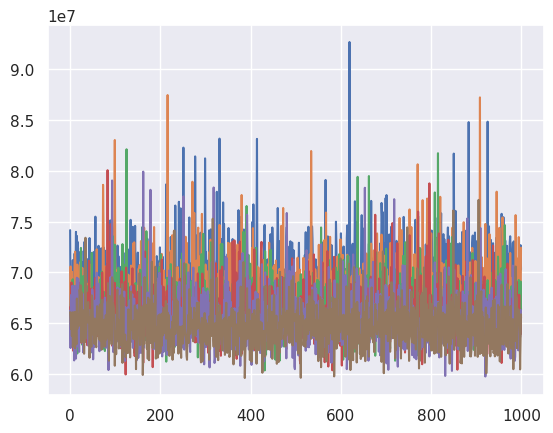

In [11]:
rng_key = random.PRNGKey(12300111)

accs = []
for i, nh in enumerate(num_hn):
    print('{} hidden neurons'.format(nh))
    rng_key, _rng_key = random.split(rng_key)
    guide, losses, params = model_fitting(shallow_scn, train_ds, _rng_key, nh, n_iter=10000)
    
    rng_key, _rng_key = random.split(rng_key)
    acc = model_testing(test_ds, _rng_key, shallow_scn, guide, params, nh)
    
    accs.append( acc )
    plt.plot(losses[-1000:])
    print('\n')

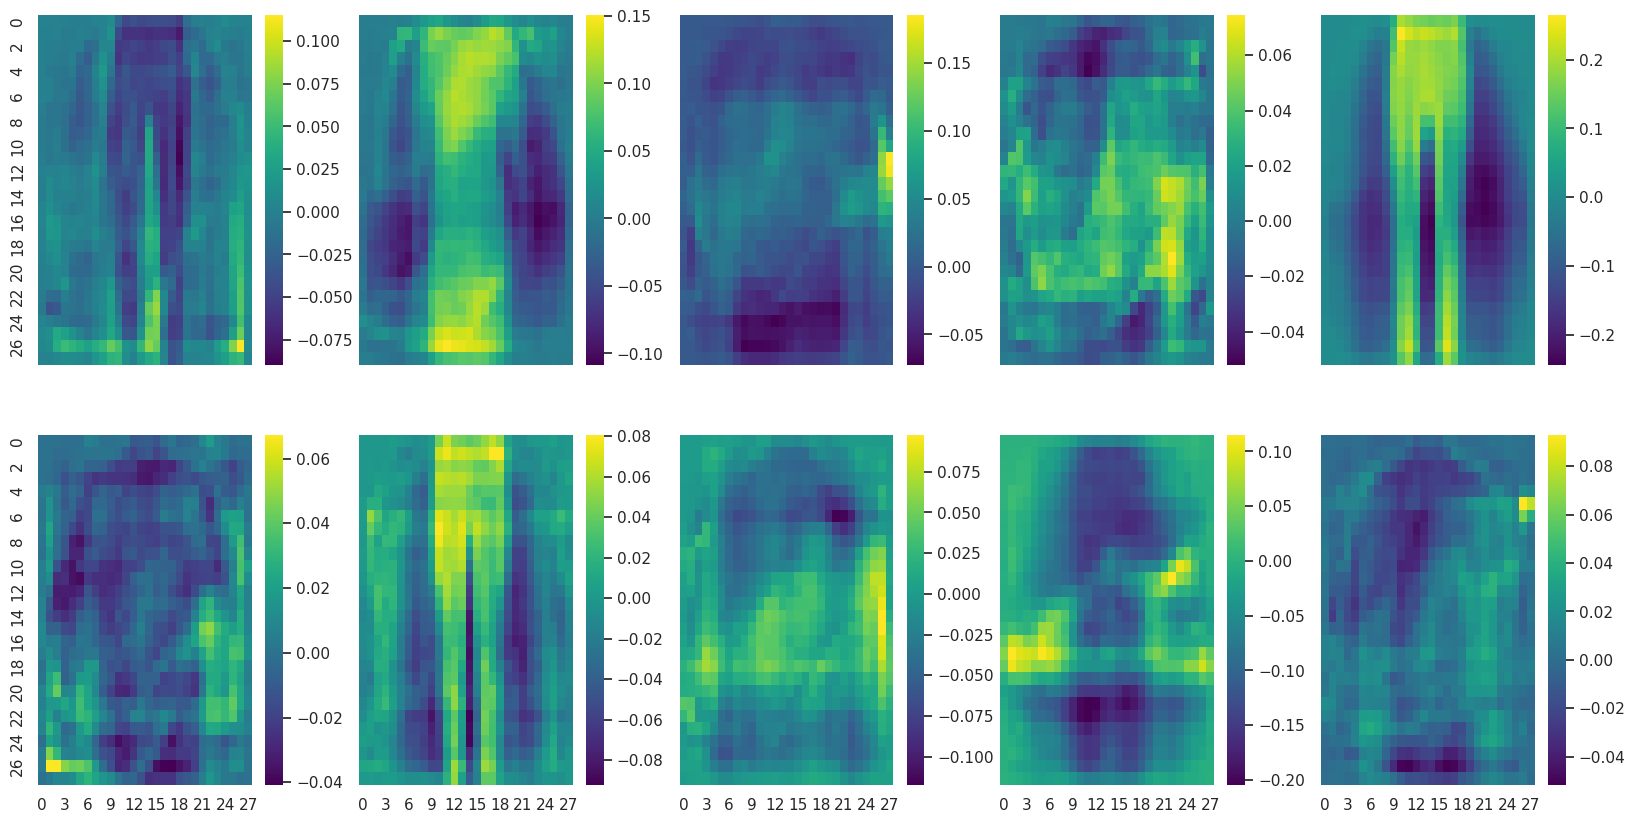

In [16]:
# plot receptive fields
fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
w1 = params['layer1.w1'] @ jnp.diag(jnp.sqrt(W)) @ jnp.linalg.inv(V)
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(w1[i].reshape(28, 28), ax=ax, cmap='viridis')

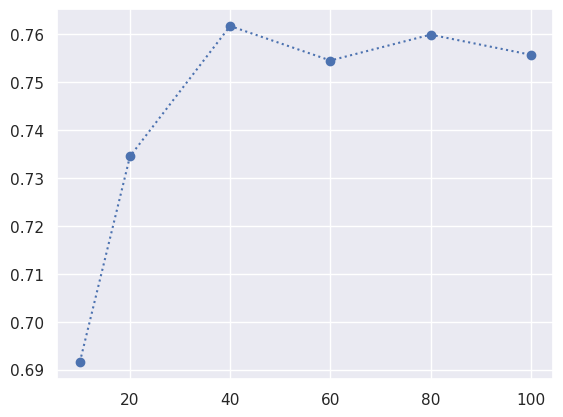

In [17]:
plt.plot(num_hn, accs, 'o:');

## Bayesian shallow sparse coding networks

As a first step to obtaining a full Bayesian treatment of sparse coding networks we will introduce 
a gaussian prior over weights
\begin{equation}
    p\left(\pmb{\Theta} \right) = \mathcal{N}\left(\pmb{W}_1; 0, 1\right)\mathcal{N}\left(\pmb{W}_2; 0, 1\right)
\end{equation}

In [18]:
from numpyro import handlers
from numpyro.distributions import constraints
from numpyro.distributions.util import safe_normalize, sum_rightmost
from numpyro.distributions.transforms import biject_to
from numpyro.infer.reparam import TransformReparam

def bayes_likelihood(W_1, b_1, W_2, b_2, lam, alpha, gamma, data_size, subsample_size, images, labels, num_labels, num_hidden, num_pixels):
#     L_inv_corr = numpyro.sample('L_inv_corr', dist.LKJCholesky(num_pixels, 1.))
#     pi = numpyro.sample('pi', dist.Gamma(2., 2.).expand([num_pixels]).to_event(1))
#     L_inv = jnp.expand_dims(jnp.sqrt(pi), -1) * L_inv_corr 
#     b_1 = L_inv @ b_1
#     numpyro.factor('scale', jnp.log(pi).sum()/2)
    with numpyro.plate("N", data_size, subsample_size=subsample_size):
        batch_x = numpyro.subsample(images, event_dim=1) # @ L_inv.T
        if labels is not None:
            batch_y = numpyro.subsample(labels, event_dim=0)
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x, one_hot(batch_y, num_labels))
            )
            numpyro.sample('images', dist.Normal(loc=a@W_1 + b_1, scale=1.).to_event(1), obs=batch_x)
            numpyro.sample('labels', dist.CategoricalLogits(a@W_2 + b_2).to_event(1), obs=batch_y)
        else:
            batch_y = None
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x)
            )
            numpyro.deterministic('logits', (a@W_2 + b_2))

def bayes_shallow_scn(images, num_hidden=1, num_labels=10, labels=None, subsample_size=None, lam=0.01, alpha=0., gamma=1., k=5):
    data_size, num_pixels = images.shape
    
    w1 = numpyro.sample(
        'layer1.w1_normal', dist.Normal(0., 1.).expand([num_hidden, num_pixels]).to_event(2)
    )
    
#     a_s = numpyro.sample('a_s', dist.Gamma(.5, 1.).expand([num_pixels - 1]).to_event(1))
#     b_s = numpyro.sample('b_s', dist.InverseGamma(.5, 1.).expand([num_pixels - 1]).to_event(1))
    
#     a_t = numpyro.sample('a_t', dist.Gamma(.5, 1.).expand([num_hidden]).to_event(1))
#     b_t = numpyro.sample('b_t', dist.InverseGamma(.5, 1.).expand([num_hidden]).to_event(1))
    
#     tau = numpyro.deterministic(
#         'tau', jnp.pad(jnp.sqrt(jnp.expand_dims(a_t * b_t, -1) * b_s * a_s), ((0, 0), (0, 1)), constant_values=(1.,))
#     )
    
    W_1 = numpyro.deterministic('W_1', safe_normalize(w1))
    
    w2 = numpyro.sample('layer2.w2_normal', dist.Normal(0., 1.).expand([num_hidden, num_labels]).to_event(2))
    W_2 = safe_normalize(w2)
    
    b_1 = jnp.zeros(num_pixels) # numpyro.sample('layer1.b1', dist.Cauchy(0., 1.).expand([num_pixels]).to_event(1))
    b_2 = numpyro.sample('layer2.b2', dist.Cauchy(0., 1.).expand([num_labels]).to_event(1))
    
    bayes_likelihood(
        W_1, b_1, W_2, b_2, lam, alpha, gamma, data_size, subsample_size, images, labels, num_labels, num_hidden, num_pixels
    )

def aux_mn(name, size, constraint=constraints.positive):
    loc = numpyro.param('loc_{}'.format(name), lambda rng_key: random.normal(rng_key, (size,))/jnp.sqrt(size))
    scale_tril = numpyro.param('scale_tril_{}'.format(name), jnp.eye(size)/10, constraint=constraints.softplus_lower_cholesky)
    z = numpyro.sample(name, dist.Normal(0, 1.).expand([size]).to_event(1), infer={"is_auxiliary": True})
    
    x = loc + scale_tril @ z
    
    transform = biject_to(constraint)

    constrained_x = transform(x)

    ld_x = transform.inv.log_abs_det_jacobian(constrained_x, x)
    ld_x1 = sum_rightmost(ld_x[..., :size//2], jnp.ndim(ld_x) - jnp.ndim(x) + 1)
    ld_x2 = sum_rightmost(ld_x[..., size//2:], jnp.ndim(ld_x) - jnp.ndim(constrained_x) + 1)
    
    return constrained_x[:size//2], constrained_x[size//2:], ld_x1, ld_x2
    
def custom_guide(images, num_hidden=1, num_labels=10, labels=None, subsample_size=None, lam=0.01, alpha=0., gamma=1. , k=5):
    data_size, num_pixels = images.shape
    
    dim = num_pixels * (num_pixels - 1) // 2
#     loc_st = numpyro.param('loc_st', jnp.zeros(dim))
#     scale_st = numpyro.param('scale_st', jnp.ones(dim)/10, constraint=constraints.softplus_positive)
#     SLC = dist.transforms.CorrCholeskyTransform()
#     affine = dist.transforms.AffineTransform(loc_st, scale_st)
#     comp = dist.transforms.ComposeTransform([affine, SLC])
#     numpyro.sample('L_inv_corr', dist.TransformedDistribution(dist.Normal(0., 1.).expand([dim]).to_event(1), comp))
    
#     loc_pi = numpyro.param('loc_pi', jnp.zeros(num_pixels))
#     scale_pi = numpyro.param('scale_pi', jnp.ones(num_pixels)/10, constraint=constraints.softplus_positive)
#     numpyro.sample('pi', dist.LogNormal(loc_pi, scale_pi).to_event(1))
    
    w1_loc = numpyro.param(
        'layer1.w1_loc', lambda rng_key: random.normal(rng_key, (num_hidden, num_pixels))/jnp.sqrt(num_pixels)
    )
    
    k1 = min((num_hidden * num_pixels // (num_hidden + num_pixels)), k)
    w1_U = numpyro.param(
        'layer1.w1_U', 
        jnp.ones((num_hidden, k1))/jnp.sqrt(k1*10)
    )
    
    w1_V = numpyro.param(
        'layer1.w1_V', 
        jnp.ones((k1, num_pixels - 1))/jnp.sqrt(k1*10)
    )
    
    w1_scale = jnp.abs(
            w1_U @ w1_V
    )
    w1_scale = jnp.pad(w1_scale, ((0, 0),(0, 1)), constant_values=(1.,))
    W_1 = numpyro.sample('layer1.w1_normal', dist.Normal(w1_loc, w1_scale).to_event(2))
    
#     size = num_pixels - 1
#     x1, x2, ld_x1, ld_x2 = aux_mn('local', 2 * size)

#     numpyro.sample('a_s', dist.Delta(x1, log_density=ld_x1, event_dim=1))
#     numpyro.sample('b_s', dist.Delta(x2, log_density=ld_x2, event_dim=1))
    
#     size = num_hidden
#     x1, x2, ld_x1, ld_x2 = aux_mn('global', 2 * size)

#     numpyro.sample('a_t', dist.Delta(x1, log_density=ld_x1, event_dim=1))
#     numpyro.sample('b_t', dist.Delta(x2, log_density=ld_x2, event_dim=1))

    w2_loc = numpyro.param(
        'layer2.w2_loc', lambda rng_key: random.normal(rng_key, (num_hidden, num_labels))/jnp.sqrt(num_labels)
    )
    
    k2 = min((num_labels * num_hidden//(num_labels + num_hidden), k))
    w2_U = numpyro.param(
        'layer2.w2_U', 
        jnp.ones((num_hidden, k2))/jnp.sqrt(k2*10)
    )
    
    w2_V = numpyro.param(
        'layer2.w2_V', 
        jnp.ones((k2, num_labels - 1))/jnp.sqrt(k2*10),
    )
    
    w2_scale = jnp.sqrt(jnp.square(w2_U @ w2_V))
    w2_scale = jnp.pad(w2_scale, ((0, 0),(0, 1)), constant_values=(1.,))
    
    W_2 = numpyro.sample('layer2.w2_normal', dist.Normal(w2_loc, w2_scale).to_event(2))
    
#     b1_loc = numpyro.param('layer1.b1_loc', lambda rng_key: random.normal(rng_key, (num_pixels,)) )
#     b1_scale = numpyro.param('layer1.b1_scale', jnp.ones(num_pixels)/10, constraint=dist.constraints.softplus_positive)
#     b_1 = numpyro.sample('layer1.b1', dist.Normal(b1_loc, b1_scale).to_event(1))
    
    b2_loc = numpyro.param('layer2.b2_loc', lambda rng_key: random.normal(rng_key, (num_labels,)) )
    b2_scale = numpyro.param('layer2.b2_scale', jnp.eye(num_labels)/10, constraint=dist.constraints.softplus_lower_cholesky)
    b_2 = numpyro.sample('layer2.b2', dist.MultivariateNormal(loc=b2_loc, scale_tril=b2_scale))
            
def model_testing(test_ds, rng_key, model, guide, params, num_hidden, num_labels=10, num_samples=100):
    pred = Predictive(model, guide=guide, params=params, num_samples=num_samples)
    sample = pred(rng_key, test_ds['image'], num_hidden=num_hidden)
    l_prob = softmax(sample['logits']).mean(0)
    acc = jnp.mean(l_prob.argmax(-1)  == test_ds['label'] )
    
    print('classification acc: ', acc)
    
    return acc

10 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:34<00:00, 106.34it/s, init loss: 74381784.0000, avg. loss [9501-10000]: 70214384.0000]


elbo:  70224120.0
classification acc:  0.74039996


20 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:34<00:00, 106.34it/s, init loss: 74020920.0000, avg. loss [9501-10000]: 68768808.0000]


elbo:  68742260.0
classification acc:  0.746


40 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:30<00:00, 110.94it/s, init loss: 72967976.0000, avg. loss [9501-10000]: 67181208.0000]


elbo:  67248310.0
classification acc:  0.7718


60 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:30<00:00, 110.52it/s, init loss: 72021504.0000, avg. loss [9501-10000]: 66117792.0000]


elbo:  66066900.0
classification acc:  0.7988


80 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:31<00:00, 109.74it/s, init loss: 71808216.0000, avg. loss [9501-10000]: 66139828.0000]


elbo:  66115610.0
classification acc:  0.8109


100 hidden neurons


100%|████████████████████████████████████████████████████████| 10000/10000 [01:35<00:00, 104.82it/s, init loss: 70963216.0000, avg. loss [9501-10000]: 65835532.0000]


elbo:  65752524.0
classification acc:  0.8172




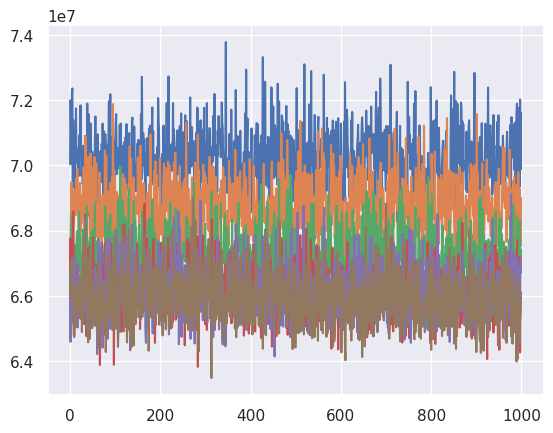

In [19]:
# Mean-field estimate with low-rank normal guide
rng_key = random.PRNGKey(11100111)

bayes_accs = []
k = 3
for i, nh in enumerate(num_hn):
    print('{} hidden neurons'.format(nh))
    rng_key, _rng_key = random.split(rng_key)
    guide, losses, params = model_fitting(
        lambda *args, **kwargs: bayes_shallow_scn(*args, k=k, **kwargs), 
        train_ds, 
        _rng_key, 
        nh, 
        n_iter=10000, 
        num_particles=10,
        guide=lambda *args, **kwargs: custom_guide(*args, k=k, **kwargs)
    )
    
    rng_key, _rng_key = random.split(rng_key)
    acc = model_testing(test_ds, _rng_key, bayes_shallow_scn, guide, params, nh)
    
    bayes_accs.append( acc )
    plt.plot(losses[-1000:])
    print('\n')

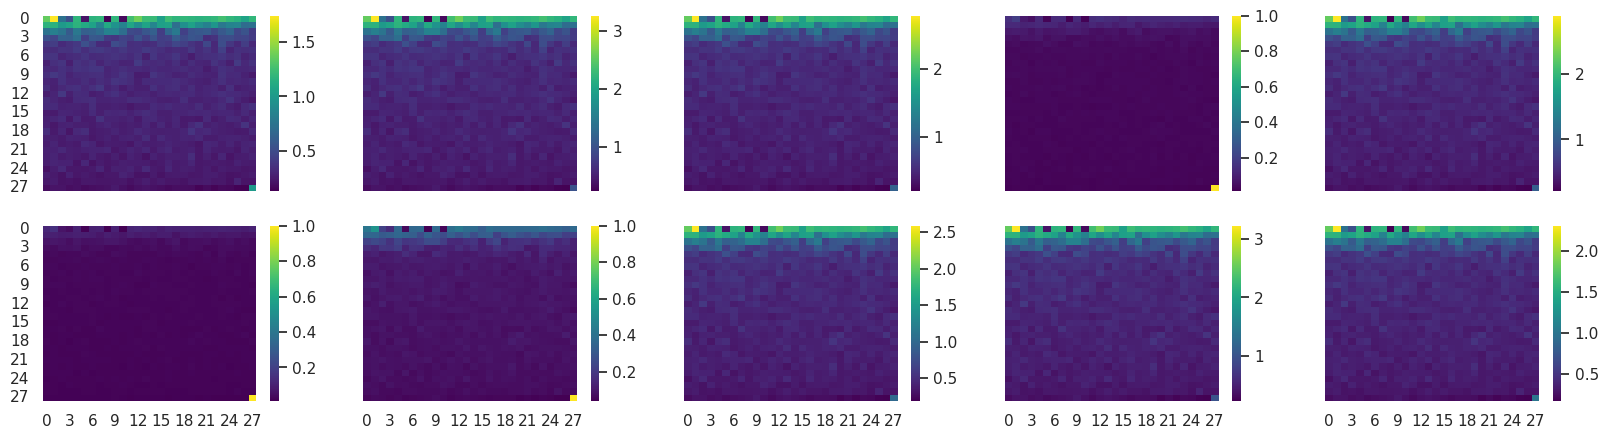

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5), sharex=True, sharey=True)

w1_U = params['layer1.w1_U']
w1_V = params['layer1.w1_V']
layer1_w1_scale = jnp.pad(jnp.sqrt(jnp.square(w1_U @ w1_V)), ((0, 0), (0, 1)), constant_values=(1.,))
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(layer1_w1_scale[i].reshape(28, 28), ax=ax, cmap='viridis')

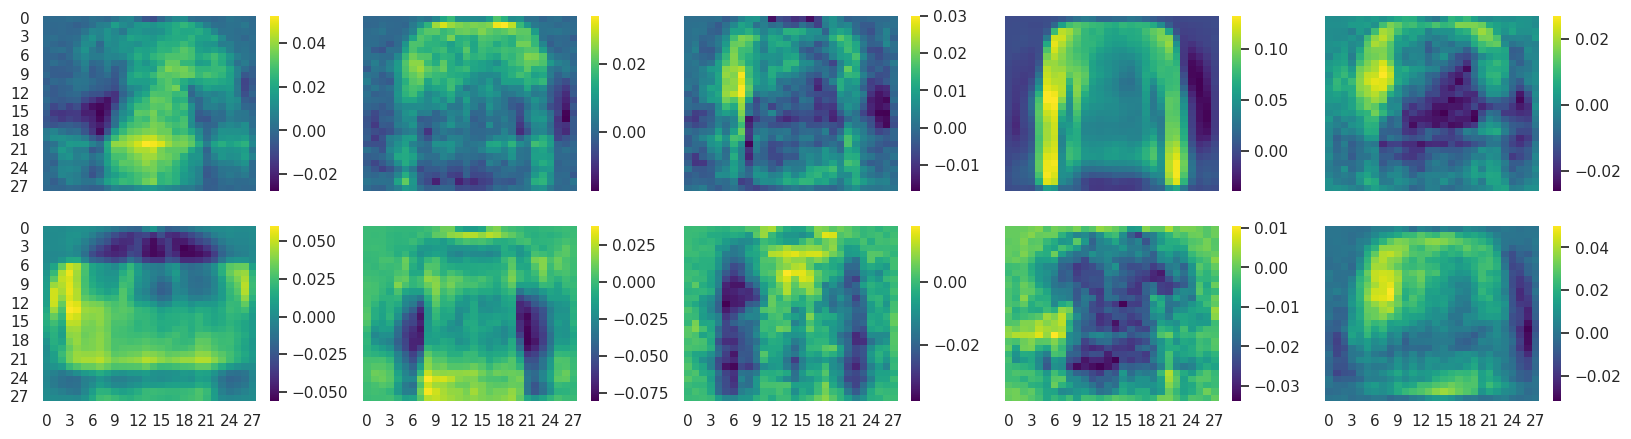

In [26]:
pred = Predictive(bayes_shallow_scn, guide=guide, params=params, num_samples=1)
sample = pred(rng_key, train_ds['image'], num_hidden=nh, labels=train_ds['label'])

fig, axes = plt.subplots(2, 5, figsize=(20, 5), sharex=True, sharey=True)
w1 = sample['W_1'].mean(0) @ jnp.diag(jnp.sqrt(W)) @ jnp.linalg.inv(V)
for i, ax in enumerate(axes.flatten()):
    sns.heatmap(w1[i].reshape(28, 28), ax=ax, cmap='viridis')

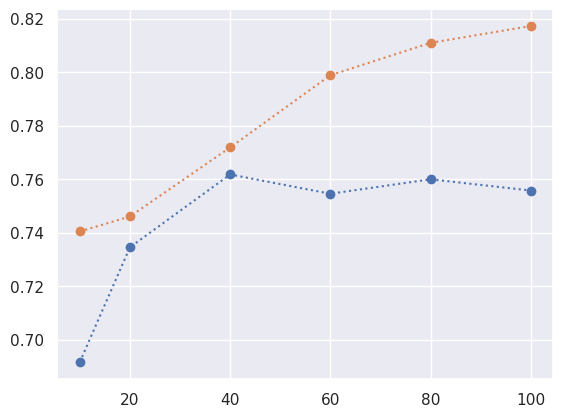

In [20]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');

## Sparse Bayesian shallow neural network with whitening

In [ ]:
def bayes_likelihood(W_1, b_1, W_2, b_2, lam, alpha, gamma, data_size, subsample_size, images, labels, num_labels, num_hidden, num_pixels):
    L_inv_corr = numpyro.sample('L_inv_corr', dist.LKJCholesky(num_pixels, 1.))
    pi = numpyro.sample('pi', dist.Gamma(2., 2.).expand([num_pixels]).to_event(1))
    L_inv = jnp.expand_dims(jnp.sqrt(pi), -1) * L_inv_corr 
    b_1 = L_inv @ b_1
    numpyro.factor('scale', jnp.log(jnp.diag(L_inv)).sum()/2)
    with numpyro.plate("N", data_size, subsample_size=subsample_size):
        batch_x = numpyro.subsample(images, event_dim=1) @ L_inv.T
        if labels is not None:
            batch_y = numpyro.subsample(labels, event_dim=0)
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x, one_hot(batch_y, num_labels))
            )
            numpyro.sample('images', dist.Normal(loc=a@W_1 + b_1, scale=1.).to_event(1), obs=batch_x)
            numpyro.sample('labels', dist.CategoricalLogits(a@W_2 + b_2).to_event(1), obs=batch_y)
        else:
            batch_y = None
            a = numpyro.deterministic(
                'a', map_state(num_hidden, W_1, b_1, W_2, b_2, lam, alpha, gamma, batch_x)
            )
            numpyro.deterministic('logits', (a@W_2 + b_2))

def bayes_shallow_scn(images, num_hidden=1, num_labels=10, labels=None, subsample_size=None, lam=0.01, alpha=0., gamma=1., k=5):
    data_size, num_pixels = images.shape
    
    w1 = numpyro.sample(
        'layer1.w1_normal', dist.Normal(0., 1.).expand([num_hidden, num_pixels]).to_event(2)
    )
    
#     a_s = numpyro.sample('a_s', dist.Gamma(.5, 1.).expand([num_pixels - 1]).to_event(1))
#     b_s = numpyro.sample('b_s', dist.InverseGamma(.5, 1.).expand([num_pixels - 1]).to_event(1))
    
#     a_t = numpyro.sample('a_t', dist.Gamma(.5, 1.).expand([num_hidden]).to_event(1))
#     b_t = numpyro.sample('b_t', dist.InverseGamma(.5, 1.).expand([num_hidden]).to_event(1))
    
#     tau = numpyro.deterministic(
#         'tau', jnp.pad(jnp.sqrt(jnp.expand_dims(a_t * b_t, -1) * b_s * a_s), ((0, 0), (0, 1)), constant_values=(1.,))
#     )
    
    W_1 = numpyro.deterministic('W_1', safe_normalize(w1))
    
    w2 = numpyro.sample('layer2.w2_normal', dist.Normal(0., 1.).expand([num_hidden, num_labels]).to_event(2))
    W_2 = safe_normalize(w2)
    
    b_1 = numpyro.sample('layer1.b1', dist.Cauchy(0., 1.).expand([num_pixels]).to_event(1))
    b_2 = numpyro.sample('layer2.b2', dist.Cauchy(0., 1.).expand([num_labels]).to_event(1))
    
    bayes_likelihood(
        W_1, b_1, W_2, b_2, lam, alpha, gamma, data_size, subsample_size, images, labels, num_labels, num_hidden, num_pixels
    )

def aux_mn(name, size, constraint=constraints.positive):
    loc = numpyro.param('loc_{}'.format(name), lambda rng_key: random.normal(rng_key, (size,))/jnp.sqrt(size))
    scale_tril = numpyro.param('scale_tril_{}'.format(name), jnp.eye(size)/10, constraint=constraints.softplus_lower_cholesky)
    z = numpyro.sample(name, dist.Normal(0, 1.).expand([size]).to_event(1), infer={"is_auxiliary": True})
    
    x = loc + scale_tril @ z
    
    transform = biject_to(constraint)

    constrained_x = transform(x)

    ld_x = transform.inv.log_abs_det_jacobian(constrained_x, x)
    ld_x1 = sum_rightmost(ld_x[..., :size//2], jnp.ndim(ld_x) - jnp.ndim(x) + 1)
    ld_x2 = sum_rightmost(ld_x[..., size//2:], jnp.ndim(ld_x) - jnp.ndim(constrained_x) + 1)
    
    return constrained_x[:size//2], constrained_x[size//2:], ld_x1, ld_x2
    
def custom_guide(images, num_hidden=1, num_labels=10, labels=None, subsample_size=None, lam=0.01, alpha=0., gamma=1. , k=5):
    data_size, num_pixels = images.shape
    
    dim = num_pixels * (num_pixels - 1) // 2
    loc_st = numpyro.param('loc_st', jnp.zeros(dim))
    scale_st = numpyro.param('scale_st', jnp.ones(dim)/10, constraint=constraints.softplus_positive)
    SLC = dist.transforms.CorrCholeskyTransform()
    affine = dist.transforms.AffineTransform(loc_st, scale_st)
    comp = dist.transforms.ComposeTransform([affine, SLC])
    numpyro.sample('L_inv_corr', dist.TransformedDistribution(dist.Normal(0., 1.).expand([dim]).to_event(1), comp))
    
    loc_pi = numpyro.param('loc_pi', jnp.zeros(num_pixels))
    scale_pi = numpyro.param('scale_pi', jnp.ones(num_pixels)/10, constraint=constraints.softplus_positive)
    numpyro.sample('pi', dist.LogNormal(loc_pi, scale_pi).to_event(1))
    
    w1_loc = numpyro.param(
        'layer1.w1_loc', lambda rng_key: random.normal(rng_key, (num_hidden, num_pixels))/jnp.sqrt(num_pixels)
    )
    
    k1 = min((num_hidden * num_pixels // (num_hidden + num_pixels)), k)
    w1_U = numpyro.param(
        'layer1.w1_U', 
        jnp.ones((num_hidden, k1))/jnp.sqrt(k1*10)
    )
    
    w1_V = numpyro.param(
        'layer1.w1_V', 
        jnp.ones((k1, num_pixels - 1))/jnp.sqrt(k1*10)
    )
    
    w1_scale = jnp.abs(
            w1_U @ w1_V
    )
    w1_scale = jnp.pad(w1_scale, ((0, 0),(0, 1)), constant_values=(1.,))
    W_1 = numpyro.sample('layer1.w1_normal', dist.Normal(w1_loc, w1_scale).to_event(2))
    
#     size = num_pixels - 1
#     x1, x2, ld_x1, ld_x2 = aux_mn('local', 2 * size)

#     numpyro.sample('a_s', dist.Delta(x1, log_density=ld_x1, event_dim=1))
#     numpyro.sample('b_s', dist.Delta(x2, log_density=ld_x2, event_dim=1))
    
#     size = num_hidden
#     x1, x2, ld_x1, ld_x2 = aux_mn('global', 2 * size)

#     numpyro.sample('a_t', dist.Delta(x1, log_density=ld_x1, event_dim=1))
#     numpyro.sample('b_t', dist.Delta(x2, log_density=ld_x2, event_dim=1))

    w2_loc = numpyro.param(
        'layer2.w2_loc', lambda rng_key: random.normal(rng_key, (num_hidden, num_labels))/jnp.sqrt(num_labels)
    )
    
    k2 = min((num_labels * num_hidden//(num_labels + num_hidden), k))
    w2_U = numpyro.param(
        'layer2.w2_U', 
        jnp.ones((num_hidden, k2))/jnp.sqrt(k2*10)
    )
    
    w2_V = numpyro.param(
        'layer2.w2_V', 
        jnp.ones((k2, num_labels - 1))/jnp.sqrt(k2*10),
    )
    
    w2_scale = jnp.sqrt(jnp.square(w2_U @ w2_V))
    w2_scale = jnp.pad(w2_scale, ((0, 0),(0, 1)), constant_values=(1.,))
    
    W_2 = numpyro.sample('layer2.w2_normal', dist.Normal(w2_loc, w2_scale).to_event(2))
    
    b1_loc = numpyro.param('layer1.b1_loc', lambda rng_key: random.normal(rng_key, (num_pixels,)) )
    b1_scale = numpyro.param('layer1.b1_scale', jnp.ones(num_pixels)/10, constraint=dist.constraints.softplus_positive)
    b_1 = numpyro.sample('layer1.b1', dist.Normal(b1_loc, b1_scale).to_event(1))
    
    b2_loc = numpyro.param('layer2.b2_loc', lambda rng_key: random.normal(rng_key, (num_labels,)) )
    b2_scale = numpyro.param('layer2.b2_scale', jnp.eye(num_labels)/10, constraint=dist.constraints.softplus_lower_cholesky)
    b_2 = numpyro.sample('layer2.b2', dist.MultivariateNormal(loc=b2_loc, scale_tril=b2_scale))

In [ ]:
# non-centered parameterisation
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

reparam_config = {
    "nnet/dense0.kernel": LocScaleReparam(0),
    "nnet/dense1.kernel": LocScaleReparam(0),
}
reparam_model = reparam(
    sparse_bayes_shallownet, config=reparam_config
)

In [ ]:
# MAP estimate
rng_key = random.PRNGKey(10234501)

sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000)
    )

In [ ]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');
plt.plot(num_hn, sparse_accs, 'o:');

In [ ]:
# mean-field posterior
rng_key = random.PRNGKey(102348221)
sparse_accs = []
for n_neurons in num_hn:
    rng_key, _rng_key = random.split(rng_key)
    sparse_accs.append(
        bayes_fitting_and_testing(reparam_model, train_ds, test_ds, _rng_key, n_neurons, n_iter=20000, approx='mean-field')
    )

In [ ]:
plt.plot(num_hn, accs, 'o:');
plt.plot(num_hn, bayes_accs, 'o:');
plt.plot(num_hn, sparse_accs, 'o:');

In [ ]:
# whitening images
# import numpy as np
# from scipy.linalg import expm, logm, fractional_matrix_power
# mean = train_ds['image'].mean(-2)
# centered = train_ds['image'] - mean
# centered = np.array(centered).astype(np.double)
# std = np.std(centered, 0)
# centered[:, std > .0] /= std[std > .0]
# p =  std > 1e-2
# changing = centered[:, p]
# C = np.cov(changing.T)
# C = (C + C.T)/2
# L = fractional_matrix_power(C, -0.5)

# centered[:, p] = changing @ L
# images = centered + mean

# fig, axes = plt.subplots(2, 5, figsize=(16, 5))
# for i, ax in enumerate(axes.flatten()):
#     sns.heatmap(train_ds['image'][i].reshape(28, 28), ax=ax)

# fig, axes = plt.subplots(2, 5, figsize=(16, 5))
# for i, ax in enumerate(axes.flatten()):
#     sns.heatmap(images[i].reshape(28, 28), ax=ax)
    
# train_ds['image'] = jnp.array(images)

# centered = test_ds['image'] - mean
# centered = np.array(centered).astype(np.double)
# centered[:, p] = centered[:, p] @ L
# test_ds['image'] = jnp.array(centered + mean)